In [1]:
import operator 
import math

class KNN():
    def __init__(self, K=5):
        self.K = K
    
    def euclideanDistance(self, vector1, vector2):
        distance = 0
        for a,b in zip(vector1, vector2):
            distance += pow((float(a) - float(b)), 2)
        return math.sqrt(distance)

    def getNeighbors(self, trainingSet, testInstance):
        distances = []
        for x in trainingSet:
            dist = self.euclideanDistance(testInstance.EigenValues, x.EigenValues)
            distances.append((x, dist))
        distances.sort(key=operator.itemgetter(1))
        neighbors = []
        for x in range(self.K):
            neighbors.append(distances[x][0])
        return neighbors

    def getResponse(self, neighbors):
        classVotes = {}
        for x in range(len(neighbors)):
            response = neighbors[x].SuperPop
            if response in classVotes:
                classVotes[response] += 1
            else:
                classVotes[response] = 1
        sortedVotes = sorted(classVotes.iteritems(), key=operator.itemgetter(1), reverse=True)
        return sortedVotes[0][0]

In [17]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import random


ControlPanel = "integrated_call_samples_v3.20130502.ALL.panel"
EVEC = "data/RGN.plus.HapMap.pca.evec"

class Control:
    def __init__(self, row):
        self.ID, self.Pop, self.SuperPop, self.Gender = row
        
class Evec:
    def __init__(self, row):
        self.ID = row[0].split(":")[-1]
        self.Partition = row[-1]
        self.EigenValues = row[1:-1]
        
class Dev:
    def __init__(self):
        self.ControlPanelFil = ControlPanel
        self.EvecFil = EVEC
    def loadControlPanel(self):
        # sample  pop     super_pop       gender
        self.ControlPanel = {}
        fin = open(self.ControlPanelFil, 'rb')
        reader = csv.reader(fin, delimiter='\t')
        header = reader.next()
        for row in reader:
            Indv = Control(row)
            self.ControlPanel[Indv.ID] = Indv
    def loadEigenValue(self):
        fin = open(self.EvecFil, 'rb')
        self.Colors = {'SAS':"green" , 'EAS':"blue", 'AMR':"orange", 'AFR':"purple", 'EUR':"red", 'CASE':"grey"}
        self.SuperPops = {'SAS':[] , 'EAS':[], 'AMR':[], 'AFR':[], 'EUR':[]} #'SAS', 'EAS', 'AMR', 'AFR', 'EUR'
        self.Cases = []
        header = fin.next()
        for line in fin:
            row = line.strip().split()
            evec = Evec(row)
            if evec.Partition == "Case":
                self.Cases.append(evec)
            elif evec.Partition == "Control":
                try:
                    superpop = self.ControlPanel[evec.ID].SuperPop
                    self.SuperPops[superpop].append(evec)
                except KeyError:
                    print "Sample %s marked as control but not in Control Panel" % (evec.ID)
                
        
    def ReduceSuperPop(self):
        self.Colors = {'SAS':"green" , 'EAS':"blue", 'AMR':"orange", 'AFR':"purple", 'EUR':"red", 'CASE':"grey"}
        self.SuperPops = {'SAS':[] , 'EAS':[], 'AMR':[], 'AFR':[], 'EUR':[]} #'SAS', 'EAS', 'AMR', 'AFR', 'EUR'
        for k,v in self.ControlPanel.items():
            superpop = v.SuperPop
            if superpop not in self.SuperPops:
                print "{}'s SuperPop {} is not included in default SuperPop: {}".format(k, superpop, "SAS, EAS, AMR, AFR, EUR")
            else:
                self.SuperPops[superpop].append(k)
    
    def ReadEigenvaluesFromList(self, List, idx1, idx2):
        X, Y = [], []
        for evec in List:
            X.append(evec.EigenValues[idx1])
            Y.append(evec.EigenValues[idx2])
        return X, Y
    
    def Plot(self, OutName):
        with PdfPages('%s.pdf'%OutName, 'wb') as pdf:
            for PCx, PCy in [(1,2),(2,3),(3,4),(4,5)]:
                plt.figure(figsize=(15, 15))
                for k,SuperPop in self.SuperPops.items():
                    color = self.Colors[k]
                    X, Y = self.ReadEigenvaluesFromList(SuperPop, PCx-1, PCy-1)
                    plt.scatter(X, Y, color=color, marker='x', label=k)
                X, Y = self.ReadEigenvaluesFromList(self.Cases, PCx-1, PCy-1)
                plt.scatter(X, Y, color="grey", marker='o', label="Cases")
                plt.xlabel('PC%d'%PCx)
                plt.ylabel('PC%d'%PCy)
                plt.title('PC%d - PC%d'%(PCx,PCy))
                plt.legend(loc='upper right')
                plt.grid(True)
                #plt.show()
                pdf.savefig()
                plt.close()

    def MakeTrainingSetKNN(self):
        res = []
        for k,v in self.SuperPops.items():
            #print k, v
            for evec in v:
                evec.SuperPop = k
                res.append(evec)
        return res
                
    def MarkerWithKNN(self):
        with open("CaseAnnotationKNN.txt", 'wb') as fout:
            knn = KNN(5)
            TrainingSet = self.MakeTrainingSetKNN()
            for case in self.Cases:
                neighbors = knn.getNeighbors(TrainingSet, case)
                response = knn.getResponse(neighbors)
                fout.write("%s\t%s\t%s\n"%(case.ID, response,','.join(case.EigenValues)))
        
    def MakeTrainingSetSVM(self):
        res = []
        for k,v in self.SuperPops.items():
            for evec in v:
                evec.SuperPop = k
                res.append(evec)
        random. shuffle(res)
        Data = [x.EigenValues for x in res]
        Label = [x.SuperPop for x in res]
        return Data, Label
    
    def MarkerWithSVM(self):
        with open("CaseAnnotationSVM.txt", 'wb') as fout:
            TrainingSet, TrainingLabel = self.MakeTrainingSetSVM()
            svm = Support_Vector_Machine(TrainingSet, TrainingLabel)
            svm.fit()
            for case in self.Cases:
                response = svm.predict(case.EigenValues)
                fout.write("%s\t%s\t%s\n"%(case.ID, response,','.join(case.EigenValues)))
    

        

In [18]:
from sklearn import svm
import time

class Support_Vector_Machine:
    def __init__(self, TrainingData, TrainingLabels):
        kernel = 'rbf'
        self.svm = svm.SVC(kernel=kernel, gamma=10)
        self.trainingData = TrainingData
        self.trainingLabels = TrainingLabels

    # train
    def fit(self):
        s_time = time.time()
        print "Fitting Model..."
        self.svm.fit(self.trainingData, self.trainingLabels)
        print "Done with Fitting, used %.4f secs." % (time.time() - s_time)

    def predict(self, case):
        dec = self.svm.predict(case)[0]
        return dec


In [19]:
instance = Dev()
instance.loadControlPanel()
instance.loadEigenValue()
#instance.ReduceSuperPop()
#instance.Plot("RGN")
instance.MarkerWithKNN()
instance.MarkerWithSVM()

Fitting Model...
Done with Fitting, used 0.0404 secs.


/Users/jiayao/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/jiayao/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/jiayao/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl

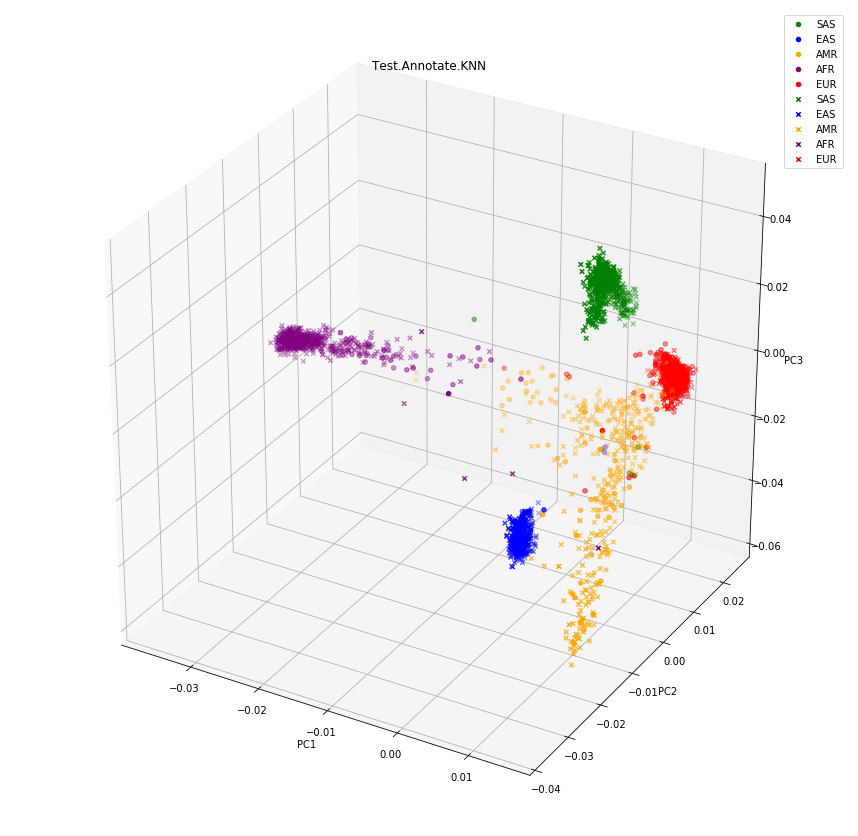

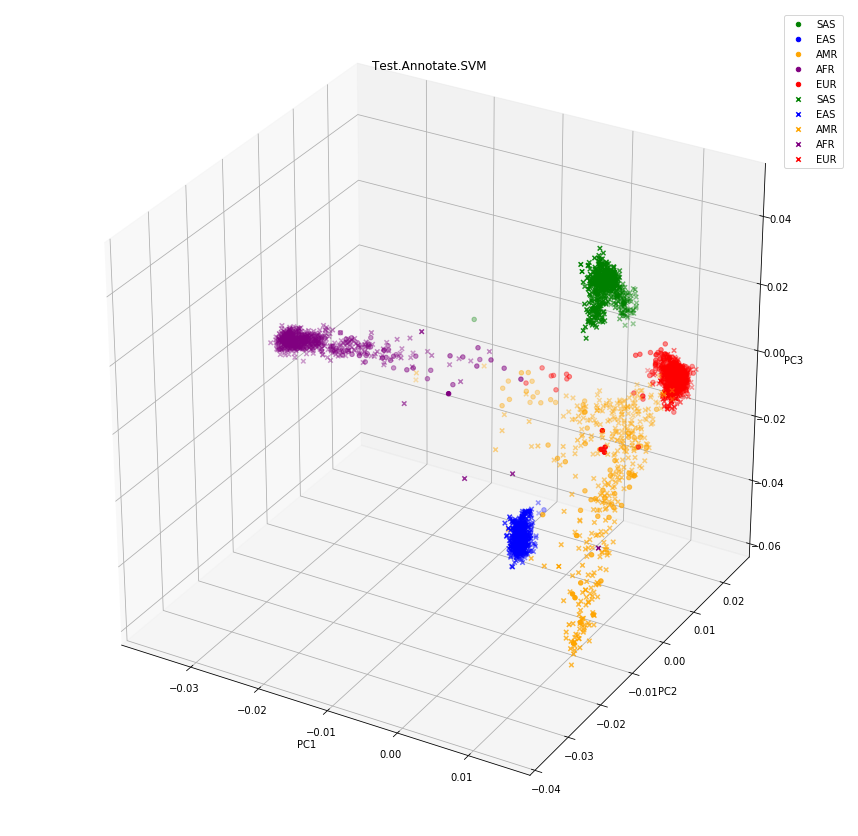

In [32]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
#Validation
class Evec:
    def __init__(self, row):
        self.ID, self.Superpop = row[0], row[1]
        self.EigenValues = row[2].split(",")

class Evec_old:
    def __init__(self, row):
        self.ID = row[0].split(":")[-1]
        self.Partition = row[-1]
        self.EigenValues = row[1:-1]
        
class Validation:
    def __init__(self, fname):
        self.fname = fname
        self.ControlPanelFil = ControlPanel
        self.EvecFil = EVEC
        
    def run(self,PDFName):
        self.loadCase()
        self.loadControlPanel()
        self.loadEigenValue()
        self.Plot(PDFName)
        self.Plot3D(PDFName)
        
        
    def loadCase(self):
        fin = open(self.fname, 'rb')
        self.Colors = {'SAS':"green" , 'EAS':"blue", 'AMR':"orange", 'AFR':"purple", 'EUR':"red", 'CASE':"grey"}
        self.SuperPops_cases = {'SAS':[] , 'EAS':[], 'AMR':[], 'AFR':[], 'EUR':[]} #'SAS', 'EAS', 'AMR', 'AFR', 'EUR'
        for line in fin:
            row = line.strip().split()
            evec = Evec(row)
            try:
                self.SuperPops_cases[evec.Superpop].append(evec)
            except KeyError:
                print "Sample %s marked as %s but not in SuperPop Panel" % (evec.ID, case.Superpop)
    
    def ReadEigenvaluesFromList(self, List, idx1, idx2):
        X, Y = [], []
        for evec in List:
            X.append(evec.EigenValues[idx1])
            Y.append(evec.EigenValues[idx2])
        return X, Y
    
    def loadControlPanel(self):
        # sample  pop     super_pop       gender
        self.ControlPanel = {}
        fin = open(self.ControlPanelFil, 'rb')
        reader = csv.reader(fin, delimiter='\t')
        header = reader.next()
        for row in reader:
            Indv = Control(row)
            self.ControlPanel[Indv.ID] = Indv

                    
    def loadEigenValue(self):
        fin = open(self.EvecFil, 'rb')
        self.Colors = {'SAS':"green" , 'EAS':"blue", 'AMR':"orange", 'AFR':"purple", 'EUR':"red", 'CASE':"grey"}
        self.SuperPops = {'SAS':[] , 'EAS':[], 'AMR':[], 'AFR':[], 'EUR':[]} #'SAS', 'EAS', 'AMR', 'AFR', 'EUR'
        self.Cases = []
        header = fin.next()
        for line in fin:
            row = line.strip().split()
            evec = Evec_old(row)
            if evec.Partition == "Case":
                self.Cases.append(evec)
            elif evec.Partition == "Control":
                try:
                    superpop = self.ControlPanel[evec.ID].SuperPop
                    self.SuperPops[superpop].append(evec)
                except KeyError:
                    print "Sample %s marked as control but not in Control Panel" % (evec.ID)
                
    
    def ReadEigenvaluesFromList(self, List, idx1, idx2):
        X, Y = [], []
        for evec in List:
            X.append(evec.EigenValues[idx1])
            Y.append(evec.EigenValues[idx2])
        return X, Y
                    
    def Plot(self, OutName):
        with PdfPages('%s.pdf'%OutName, 'wb') as pdf:
            
            for PCx, PCy in [(1,2),(2,3),(3,4),(4,5)]:
                plt.figure(figsize=(15, 15))
                # Plot Cases
                for k,SuperPop in self.SuperPops_cases.items():
                    color = self.Colors[k]
                    X, Y = self.ReadEigenvaluesFromList(SuperPop, PCx-1, PCy-1)
                    plt.scatter(X, Y, color=color, marker='o', label=k)
                # Plot Controls
                for k,SuperPop in self.SuperPops.items():
                    color = self.Colors[k]
                    X, Y = self.ReadEigenvaluesFromList(SuperPop, PCx-1, PCy-1)
                    plt.scatter(X, Y, color=color, marker='x', label=k)
                
                plt.xlabel('PC%d'%PCx)
                plt.ylabel('PC%d'%PCy)
                plt.title('PC%d - PC%d'%(PCx,PCy))
                plt.legend(loc='upper right')
                plt.grid(True)
                #plt.show()
                pdf.savefig()
                plt.close()
                
    def Plot3D(self, OutName):
        fig = plt.figure(figsize=(15, 15))
        ax = fig.add_subplot(111, projection='3d')
        # Plot Cases
        for k,SuperPop in self.SuperPops_cases.items():
            color = self.Colors[k]
            X, Y, Z = [], [], []
            for evec in SuperPop:
                X.append(float(evec.EigenValues[0]))
                Y.append(float(evec.EigenValues[1]))
                Z.append(float(evec.EigenValues[2]))
            ax.scatter(X, Y, Z, c=color, marker='o', label=k)
        # Plot Controls
        for k,SuperPop in self.SuperPops.items():
            color = self.Colors[k]
            X, Y, Z = [], [], []
            for evec in SuperPop:
                X.append(float(evec.EigenValues[0]))
                Y.append(float(evec.EigenValues[1]))
                Z.append(float(evec.EigenValues[2]))
            ax.scatter(X, Y, Z, c=color, marker='x',label=k)

        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        plt.title(OutName)
        plt.legend(loc='upper right')
        #plt.grid(True)
        plt.show()

                
test = Validation("CaseAnnotationKNN.txt")
test.run("Test.Annotate.KNN")
test = Validation("CaseAnnotationSVM.txt")
test.run("Test.Annotate.SVM")     